# Notebook 2/6: Validation Strategy
## Avoiding Data Leakage and Generalizing to New Participants

A critical part of this project is to build a model that **generalizes to new people**, not just to new timestamps from the same individual.  
This means that a standard random `train_test_split()` is **not appropriate** for time-series data collected from multiple subjects.

#### Why a random split causes data leakage
If we randomly split rows into train and test:
- the **same participant** appears in both sets,
- pressure and heat flux patterns are highly person-specific,
- the model sees almost identical signals during training and testing.

This artificially inflates performance and does **not** reflect real deployment conditions.  
In reality, the model must work for a **new person** who was not seen during training.

#### Our validation approach
We adopt a **subject-wise split** (participant-based validation):
- the dataset is split by **participant_id**, not by rows,
- some participants are reserved as the **test set**,
- the model is trained only on the remaining participants.

This strategy prevents data leakage and allows us to estimate how well the model performs on **unseen individuals**, which matches the real-world objective of personalized thermal comfort prediction.


### Choosing 4 Participants for the Test Set Using PCA

To build a model that **generalizes to new people**, the test set must include participants who are physiologically different from those in the training set.  
Using only “average” subjects would give an overly optimistic evaluation and would not properly stress-test the model.

In addition, several participants had to be removed from the dataset due to inconsistent sensor recordings  
(F4, F9, F10, M4, M9, M10).  
The test participants were therefore selected among the remaining subjects only.

#### Method: PCA and Clustering on Personal Characteristics

We used the table of personal characteristics (height, weight, BMI, fat-free mass, skeletal muscle mass, intra- and extracellular water, age, etc.) and followed these steps:

1. **Standardization**  
   All numerical features were standardized (zero mean, unit variance) to make them comparable.

2. **Principal Component Analysis (PCA)**  
   We applied PCA and projected each participant into a 2-dimensional space (PC1, PC2).  
   PC1 captures most of the variability related to overall body size and mass (height, weight, FFM, SMM, BMI),  
   while PC2 reflects finer differences in body composition and water distribution (ICW, ECW, ECW\_R, etc.).

3. **Clustering in PCA Space**  
   In the (PC1, PC2) space, we ran a K-means clustering with **4 clusters**.  
   Each cluster corresponds to a group of participants with similar anthropometric profiles.

4. **Selecting One Representative per Cluster**  
   For each cluster, we selected the participant **closest to the cluster centre** (minimum Euclidean distance in PCA space).  
   This gives four subjects that are:
   - physiologically diverse,
   - representative of distinct regions of the participant space,
   - and not affected by data-quality issues.


In [1]:
from utils.Data_extraction_utils import *
from utils.Validation_subjectwise_utils import *

In [2]:
# Load participant characteristics
participants = pd.read_csv('PersonalCharacteristicsOfSubjects/personal_characteristics.csv')

# Columns in the file:
# ['Subject', 'Sex', 'Height', 'Waist', 'Weight', 'FFM', 'SMM',
#  'ICW', 'ECW', 'BMI', 'PBF', 'BMR', 'Age', 'TW', 'ECW_R']

print("All subjects in characteristics file:")
print(sorted(participants["Subject"].unique()))

All subjects in characteristics file:
['F1', 'F10', 'F11', 'F12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'M1', 'M10', 'M11', 'M12', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


In [3]:
# Remove subjects with unreliable sensor data
bad_subjects = {"F4", "F9", "F10", "M4", "M9", "M10"}

participants_good = participants[~participants["Subject"].isin(bad_subjects)].copy()
print("\nSubjects kept for analysis (after filtering):")
print(sorted(participants_good["Subject"].unique()))
print("Number of subjects kept:", len(participants_good))


Subjects kept for analysis (after filtering):
['F1', 'F11', 'F12', 'F2', 'F3', 'F5', 'F6', 'F7', 'F8', 'M1', 'M11', 'M12', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8']
Number of subjects kept: 18


In [4]:
# Prepare numerical features for PCA
feature_cols = [
    "Height", "Waist", "Weight", "FFM", "SMM",
    "ICW", "ECW", "BMI", "PBF", "BMR", "Age", "TW", "ECW_R"
]

X = participants_good[feature_cols].values

# Standardization is essential before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)

participants_good["PC1"] = X_pca[:, 0]
participants_good["PC2"] = X_pca[:, 1]

print("\nExplained variance by PC1 and PC2:",
      pca.explained_variance_ratio_)


Explained variance by PC1 and PC2: [0.65342693 0.14036999]


In [6]:
chosen_df = choose_test_subjects_sexwise_kmeans(
    participants_good=participants_good,
    n_clusters_f=2,
    n_clusters_m=2,
    random_state=0,
    n_init=10,
    prefer_female_subject="F7",     
    replace_if_selected="F11",
    verbose=True,
)

chosen_df


F-group subjects: ['F2', 'F6', 'F5', 'F7', 'F1', 'F3', 'F8', 'F11', 'F12']
F-group clusters:
cluster_sex
0    [F2, F6, F5, F1, F3, F8, F12]
1                        [F7, F11]
Name: Subject, dtype: object

M-group subjects: ['M3', 'M5', 'M1', 'M2', 'M6', 'M7', 'M8', 'M11', 'M12']
M-group clusters:
cluster_sex
0    [M2, M6, M7, M11, M12]
1          [M3, M5, M1, M8]
Name: Subject, dtype: object

Chosen subjects for the test set (2F + 2M):
   Subject Sex       PC1       PC2  cluster_sex  dist_to_center
22     F12   F -3.957067 -0.557075            0        0.779686
7       F7   F  1.156809  2.463433            1        1.188481
13      M7   M  2.808667 -1.208832            0        0.558196
5       M1   M  1.078722  0.423198            1        0.857813


,Subject,Sex,PC1,PC2,cluster_sex,dist_to_center
22,F12,F,-3.957067,-0.557075,0,0.779686
7,F7,F,1.156809,2.463433,1,1.188481
13,M7,M,2.808667,-1.208832,0,0.558196
5,M1,M,1.078722,0.423198,1,0.857813


In [7]:
# Map back to the raw IDs used in test_ids (ID_MAP from the codebase)
inv_map = {v: k for k, v in ID_MAP.items()}

print("\nMapping Subject → raw ID (for test_ids):")
test_ids = []
for subj in chosen_df["Subject"]:
    raw_id = inv_map.get(subj, "N/A")
    print(f"{subj} → {raw_id}")
    if raw_id != "N/A":
        test_ids.append(raw_id)

print("\nFinal test_ids to use in the pipeline:", test_ids)


Mapping Subject → raw ID (for test_ids):
F12 → A23
F7 → A17
M7 → K18
M1 → B11

Final test_ids to use in the pipeline: ['A23', 'A17', 'K18', 'B11']


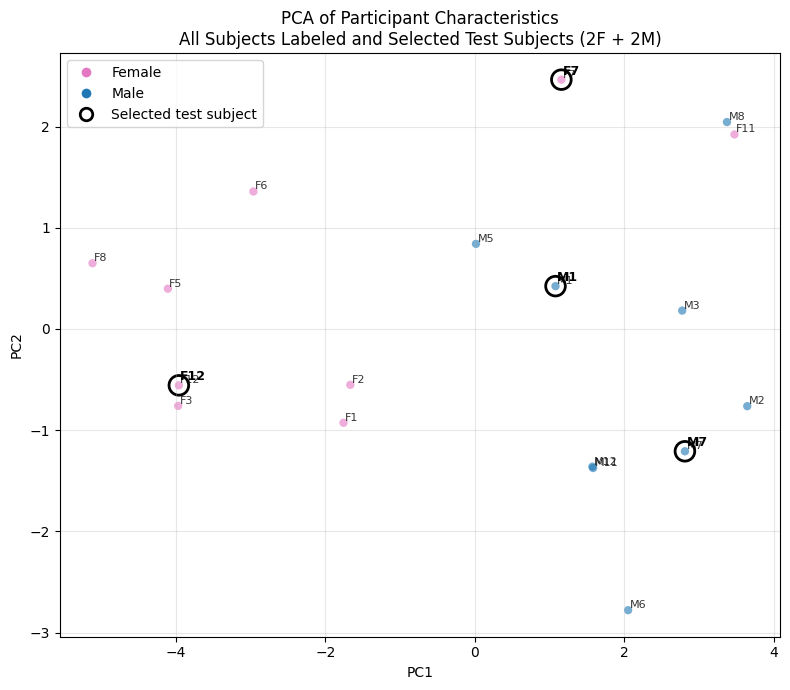

In [8]:
plot_pca_subjects_with_selection(
    participants=participants_good,
    chosen_df=chosen_df,
    title="PCA of Participant Characteristics\nAll Subjects Labeled and Selected Test Subjects (2F + 2M)",
)

### Final Choice of Test Participants

Following the PCA-based and sex-balanced selection procedure, we chose the following **four participants** for the test set.  
These participants span different physiological profiles while guaranteeing a balanced representation of **two women and two men**:

Based on the PCA analysis and the objective of creating a physiologically diverse and gender-balanced test set, we selected four participants whose characteristics represent distinct regions of the morphological feature space:

- **F12:** Female with moderate weight, low BMI, and relatively low muscle mass.
Represents lighter female profiles with lower metabolic heat production.

- **F7:** Female with higher fat percentage and slightly higher body mass than F12.
Provides contrast in female body composition (fat-to-muscle ratio, water distribution).

- **M1:** Male with average stature and balanced body composition (moderate FFM, SMM, BMI).
Represents a typical male participant profile.

- **M7:** Tall, heavier male with high muscle mass and high fat-free mass.
Represents individuals with strong heat generation and wide body-contact surface.

Together, F12, F7, M1, and M7 provide a test set that is both **balanced** by sex and diverse in body size, mass, composition, and metabolic profile.

This ensures a realistic evaluation of the model’s ability to generalize to unseen and physiologically different participants.
